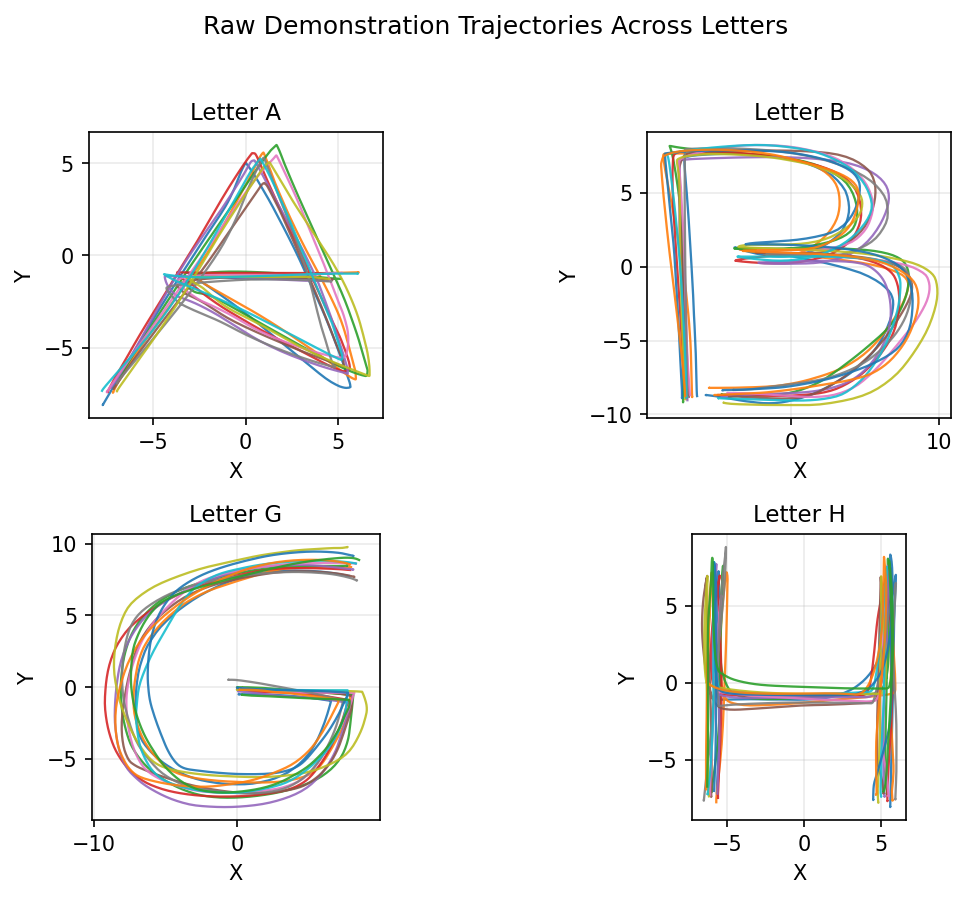

In [1]:
# --- Fig 4.1 (variant): Multi-letter panel of raw trajectories ---

import os, numpy as np, matplotlib.pyplot as plt
from scipy.io import loadmat

os.makedirs('figs', exist_ok=True)

def read_all_raw(letter):
    m = loadmat(f'../2Dletters/{letter}.mat', struct_as_record=False, squeeze_me=True)
    demos = m['demos']
    out = []
    def _to_2xT(obj):
        a = np.asarray(obj)
        while a.dtype == object and a.size == 1:
            a = np.asarray(a.item())
        a = np.squeeze(a)
        return a.T if a.shape[1] == 2 else a
    N = len(demos) if isinstance(demos, (list, tuple)) else demos.shape[-1]
    for i in range(N):
        try:    pos = _to_2xT(demos[i].pos)
        except: pos = _to_2xT(demos['pos'][i])
        out.append(pos)
    return out

letters = ['A','B','G','H']   # 可换成你需要展示的 4 个/6 个字母
n = len(letters)
rows, cols = 2, 2

plt.figure(figsize=(8, 6), dpi=150)
for i, L in enumerate(letters, 1):
    raws = read_all_raw(L)
    ax = plt.subplot(rows, cols, i)
    for pos in raws:
        ax.plot(pos[0], pos[1], linewidth=1.1, alpha=0.9)
    ax.set_aspect('equal', 'box')
    ax.set_title(f'Letter {L}', fontsize=11)
    ax.set_xlabel('X'); ax.set_ylabel('Y')
    ax.grid(True, alpha=0.25)

plt.suptitle('Raw Demonstration Trajectories Across Letters', y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.97])
plt.savefig('figs/Fig4_1_raw_multi.png', dpi=300, bbox_inches='tight')
plt.savefig('figs/Fig4_1_raw_multi.pdf', bbox_inches='tight')
plt.show()

[INFO] Letter=G  demo=0  raw_T=200 -> resampled_T=200, dt=0.0050s


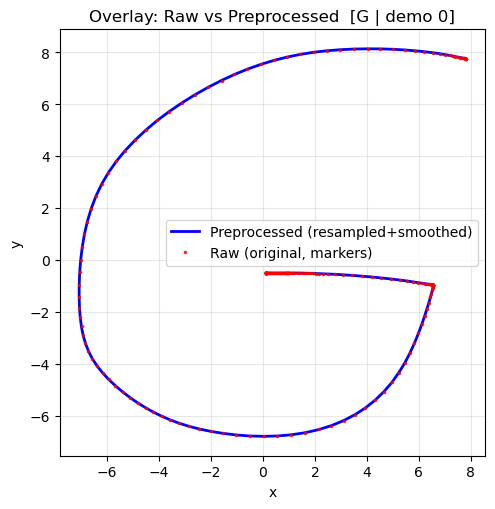

Saved: figs/preprocess_overlay_xy_G_0.png


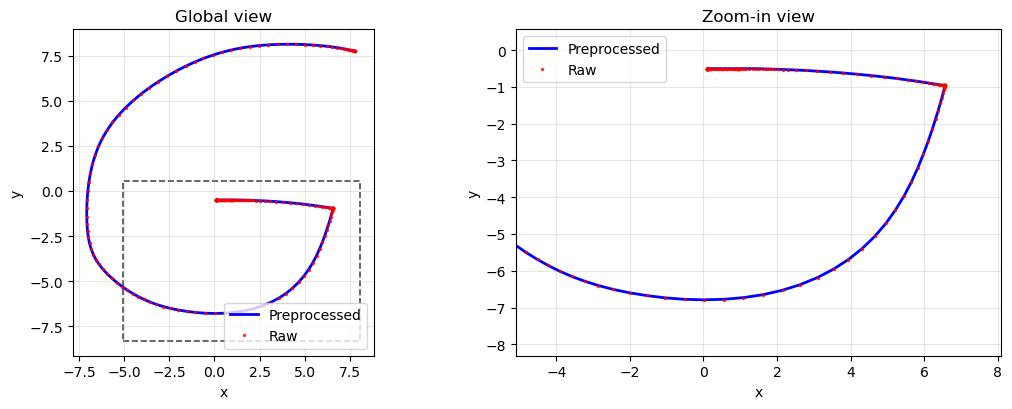

Saved: figs/preprocess_zoom_xy_G_0.png


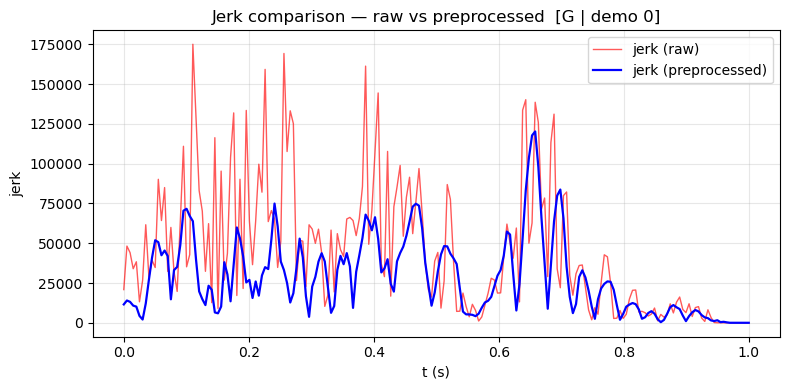

Saved: figs/preprocess_jerk_compare_G_0.png

==== Preprocessing Benefit (numbers you can cite in §4.2) ====
      jerk_rms_raw: 60720.427635
       jerk_rms_pp: 37609.686275
    jerk_rms_drop%: 38.060900
        vx_std_raw: 49.634520
         vx_std_pp: 49.581352
        vy_std_raw: 35.976697
         vy_std_pp: 35.946958
        ax_std_raw: 842.928903
         ax_std_pp: 807.861252
        ay_std_raw: 613.077056
         ay_std_pp: 589.704615
Saved stats: figs/preprocess_stats_G_0.csv


In [7]:
# =========================================
# Preprocess & Visualise: Raw vs Preprocessed Trajectory
# - 读取 2Dletters 某字母的某个 demo
# - 重采样 + 平滑 (+ 可选归一/反归一)
# - 原始 vs 预处理：叠加图 / 局部放大 / jerk 对比
# - 打印 jerk/导数统计，图片保存到 figs/
# =========================================

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import savgol_filter

# ---------- 参数（按需修改） ----------
MAT_ROOT   = '../2Dletters'     # 你的 2Dletters 目录
LETTER     = 'G'                # 要看的字母，例如 'G','B','A','H' ...
DEMO_IDX   = 0                  # 演示编号（0-based）
T          = 200                # 统一重采样长度（越大曲线越平滑）
SMOOTH     = True               # 是否平滑
WIN        = 11                 # Savitzky–Golay window（必须为奇数）
POLY       = 3                  # Savitzky–Golay 多项式阶数
NORM_MODE  = 'zscore'           # 'zscore' / 'minmax' / 'none'
SAVE_DPI   = 220

# ---------- 工具函数 ----------
def robust_pos_2xT_from_mat(mat_path, letter, demo_idx=0):
    """稳健解析 2Dletters/{letter}.mat -> 单条 demo 的 (2,T) float64"""
    m = loadmat(f"{mat_path}/{letter}.mat", struct_as_record=False, squeeze_me=True)
    demos = m['demos']
    # 兼容两种存储风格：结构体数组 和 字典字段
    try:
        pos_raw = demos[demo_idx].pos
    except Exception:
        pos_raw = demos['pos'][demo_idx]
    a = np.asarray(pos_raw)
    while a.dtype == object and a.size == 1:
        a = np.asarray(a.item())
    a = np.squeeze(a)
    # 统一到 (2,T)
    if a.ndim == 2:
        if a.shape[0] == 2:
            pos = a
        elif a.shape[1] == 2:
            pos = a.T
        else:
            raise ValueError(f"Unexpected pos shape {a.shape}")
    else:
        ax = [i for i,s in enumerate(a.shape) if s==2]
        if not ax:
            raise ValueError(f"No axis=2 in pos shape {a.shape}")
        pos = np.moveaxis(a, ax[0], 0).reshape(2, -1)
    return np.asarray(pos, dtype=np.float64)

def resample_linear(t, pos, T=200):
    """线性重采样到长度 T"""
    from scipy.interpolate import interp1d
    t  = np.asarray(t).reshape(-1)
    t0, t1 = float(t[0]), float(t[-1])
    t_rs = np.linspace(t0, t1, T)
    pos_rs = np.zeros((pos.shape[0], T))
    for d in range(pos.shape[0]):
        f = interp1d(t, pos[d], kind='linear', fill_value='extrapolate', assume_sorted=True)
        pos_rs[d] = f(t_rs)
    dt = (t1 - t0) / (T - 1) if T > 1 else 1.0
    return t_rs, pos_rs, dt

def smooth_savgol(pos, win=11, poly=3):
    if (win % 2 == 0) or (win >= pos.shape[1]):
        return pos.copy()
    out = np.zeros_like(pos)
    for d in range(pos.shape[0]):
        out[d] = savgol_filter(pos[d], window_length=win, polyorder=poly, mode='interp')
    return out

def normalize(pos, mode='zscore'):
    if mode == 'zscore':
        mean = pos.mean(axis=1, keepdims=True)
        std  = pos.std(axis=1, keepdims=True) + 1e-8
        pos_n = (pos - mean) / std
        stats = {'mode':'zscore', 'mean':mean, 'std':std}
    elif mode == 'minmax':
        mn = pos.min(axis=1, keepdims=True)
        mx = pos.max(axis=1, keepdims=True)
        rng = (mx - mn) + 1e-8
        pos_n = (pos - mn) / rng * 2 - 1
        stats = {'mode':'minmax','min':mn,'max':mx}
    else:
        pos_n = pos.copy()
        stats = {'mode':'none'}
    return pos_n, stats

def denormalize(pos_n, stats):
    m = stats.get('mode','none')
    if m == 'zscore':
        return pos_n * stats['std'] + stats['mean']
    if m == 'minmax':
        return (pos_n + 1.0) * (stats['max'] - stats['min']) / 2.0 + stats['min']
    return pos_n

def deriv(y, t):
    return np.gradient(y, t, axis=-1)

def rms(x):
    return float(np.sqrt(np.mean(np.square(x))))

# ---------- 读取 + 预处理 ----------
os.makedirs('figs', exist_ok=True)

pos_raw = robust_pos_2xT_from_mat(MAT_ROOT, LETTER, DEMO_IDX)
L = pos_raw.shape[1]
t_raw = np.linspace(0.0, 1.0, L)  # 若 .mat 自带真实时间戳，可替换为真实时间

# 重采样到统一长度
t_rs, pos_rs, dt_rs = resample_linear(t_raw, pos_raw, T=T)

# 平滑
pos_rs_smt = smooth_savgol(pos_rs, win=WIN, poly=POLY) if SMOOTH else pos_rs

# 可选归一化（很多流程在“学习”前会归一化；为了可视化直观，这里最终反归一回原尺度）
pos_n, stats = normalize(pos_rs_smt, mode=NORM_MODE)
pos_rs_smt_denorm = denormalize(pos_n, stats)  # 用于可视化的“预处理后轨迹（原尺度）”

print(f"[INFO] Letter={LETTER}  demo={DEMO_IDX}  raw_T={L} -> resampled_T={T}, dt={dt_rs:.4f}s")

# ---------- 图 1：叠加（原始=散点，预处理=实线） ----------
plt.figure(figsize=(6.2, 5.2))
plt.plot(pos_rs_smt_denorm[0], pos_rs_smt_denorm[1], 'b-', lw=2.0, label='Preprocessed (resampled+smoothed)')
plt.plot(pos_raw[0],            pos_raw[1],            'r.', ms=3,  alpha=0.8, label='Raw (original, markers)')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, alpha=0.3)
plt.xlabel('x'); plt.ylabel('y')
plt.title(f'Overlay: Raw vs Preprocessed  [{LETTER} | demo {DEMO_IDX}]')
plt.legend()
save_overlay = f'figs/preprocess_overlay_xy_{LETTER}_{DEMO_IDX}.png'
plt.tight_layout(); plt.savefig(save_overlay, dpi=SAVE_DPI); plt.show()
print('Saved:', save_overlay)

# ---------- 图 2：局部放大（选弯曲明显的一段） ----------
N = pos_rs_smt_denorm.shape[1]
idx0, idx1 = int(0.35*N), int(0.55*N)
xw = pos_rs_smt_denorm[0, idx0:idx1]; yw = pos_rs_smt_denorm[1, idx0:idx1]
pad = 0.15 * max(xw.max()-xw.min(), yw.max()-yw.min())

plt.figure(figsize=(11, 4.2))
ax = plt.subplot(1,2,1)
ax.plot(pos_rs_smt_denorm[0], pos_rs_smt_denorm[1], 'b-', lw=2.0, label='Preprocessed')
ax.plot(pos_raw[0],            pos_raw[1],            'r.', ms=3,  alpha=0.7, label='Raw')
ax.set_aspect('equal', adjustable='box'); ax.grid(True, alpha=0.3)
ax.set_title('Global view'); ax.set_xlabel('x'); ax.set_ylabel('y')
ax.legend()
rect = plt.Rectangle((xw.min()-pad, yw.min()-pad),
                     (xw.max()-xw.min()) + 2*pad,
                     (yw.max()-yw.min()) + 2*pad,
                     fill=False, ec='k', lw=1.2, ls='--', alpha=0.7)
ax.add_patch(rect)

axz = plt.subplot(1,2,2)
axz.plot(pos_rs_smt_denorm[0], pos_rs_smt_denorm[1], 'b-', lw=2.0, label='Preprocessed')
axz.plot(pos_raw[0],            pos_raw[1],            'r.', ms=3,  alpha=0.7, label='Raw')
axz.set_xlim(xw.min()-pad, xw.max()+pad); axz.set_ylim(yw.min()-pad, yw.max()+pad)
axz.set_aspect('equal', adjustable='box'); axz.grid(True, alpha=0.3)
axz.set_title('Zoom-in view'); axz.set_xlabel('x'); axz.set_ylabel('y')
axz.legend()

save_zoom = f'figs/preprocess_zoom_xy_{LETTER}_{DEMO_IDX}.png'
plt.tight_layout(); plt.savefig(save_zoom, dpi=SAVE_DPI); plt.show()
print('Saved:', save_zoom)

# ---------- 图 3：jerk 对比 & 数值统计 ----------
vx_raw = np.gradient(pos_raw[0], t_raw);  vy_raw = np.gradient(pos_raw[1], t_raw)
ax_raw = np.gradient(vx_raw,   t_raw);    ay_raw = np.gradient(vy_raw,   t_raw)
jx_raw = np.gradient(ax_raw,   t_raw);    jy_raw = np.gradient(ay_raw,   t_raw)
jerk_raw = np.sqrt(jx_raw**2 + jy_raw**2)

vx_pp  = np.gradient(pos_rs_smt_denorm[0], t_rs); vy_pp  = np.gradient(pos_rs_smt_denorm[1], t_rs)
ax_pp  = np.gradient(vx_pp,   t_rs);               ay_pp  = np.gradient(vy_pp,   t_rs)
jx_pp  = np.gradient(ax_pp,   t_rs);               jy_pp  = np.gradient(ay_pp,   t_rs)
jerk_pp = np.sqrt(jx_pp**2 + jy_pp**2)

plt.figure(figsize=(8,4))
plt.plot(t_raw, jerk_raw, 'r-', lw=1,   alpha=0.65, label='jerk (raw)')
plt.plot(t_rs,  jerk_pp,  'b-', lw=1.6,            label='jerk (preprocessed)')
plt.xlabel('t (s)'); plt.ylabel('jerk'); plt.grid(True, alpha=0.3)
plt.title(f'Jerk comparison — raw vs preprocessed  [{LETTER} | demo {DEMO_IDX}]')
plt.legend()
save_jerk = f'figs/preprocess_jerk_compare_{LETTER}_{DEMO_IDX}.png'
plt.tight_layout(); plt.savefig(save_jerk, dpi=SAVE_DPI); plt.show()
print('Saved:', save_jerk)

# 数值汇总（可写进 4.2）
def stat_str(m, s): return f"{m:.3f} ± {s:.3f}"

summary = {
    'jerk_rms_raw'  : rms(jerk_raw),
    'jerk_rms_pp'   : rms(jerk_pp),
    'jerk_rms_drop%': 100.0 * (rms(jerk_raw) - rms(jerk_pp)) / (rms(jerk_raw) + 1e-12),
    'vx_std_raw'    : float(np.std(vx_raw)), 'vx_std_pp' : float(np.std(vx_pp)),
    'vy_std_raw'    : float(np.std(vy_raw)), 'vy_std_pp' : float(np.std(vy_pp)),
    'ax_std_raw'    : float(np.std(ax_raw)), 'ax_std_pp' : float(np.std(ax_pp)),
    'ay_std_raw'    : float(np.std(ay_raw)), 'ay_std_pp' : float(np.std(ay_pp)),
}

print("\n==== Preprocessing Benefit (numbers you can cite in §4.2) ====")
for k,v in summary.items():
    if isinstance(v, float):
        print(f"{k:>18s}: {v:.6f}")
    else:
        print(f"{k:>18s}: {v}")

# 可选：把这些统计写到一个 csv 里，方便论文表格使用
import csv
csv_path = f"figs/preprocess_stats_{LETTER}_{DEMO_IDX}.csv"
with open(csv_path, "w", newline='', encoding='utf-8') as f:
    w = csv.writer(f)
    w.writerow(["metric","value"])
    for k,v in summary.items():
        w.writerow([k, v])
print("Saved stats:", csv_path)

In [11]:
# -*- coding: utf-8 -*-
# Put this cell in results_summary.ipynb or a new notebook `summarise_for_ch5.ipynb`

import os, re, glob, textwrap
import numpy as np
import pandas as pd

RESULT_DIR = "results"  # 如果不同，改这里
OUT_CSV   = os.path.join(RESULT_DIR, "summary_overall.csv")
OUT_MD    = os.path.join(RESULT_DIR, "summary_overall.md")
OUT_TXT   = os.path.join(RESULT_DIR, "summary_overall_auto_narrative.txt")

# --------- 1) 读取三个实验汇总CSV ----------
# 你现有的文件名一般是：
#   results/summary_reproduction.csv
#   results/summary_missing.csv
#   results/summary_obstacle.csv
# 若命名不同，可改下面的 mapping
exp_files = {
    "Reproduction": os.path.join(RESULT_DIR, "summary_reproduction.csv"),
    "Missing":      os.path.join(RESULT_DIR, "summary_missing.csv"),
    "Obstacle":     os.path.join(RESULT_DIR, "summary_obstacle.csv"),
}

if not all(os.path.exists(p) for p in exp_files.values()):
    print("❗找不到某些 summary_*.csv，请确认路径：", exp_files)

# --------- 2) 工具：解析 “均值 ± 标准差” ----------
pm_re = re.compile(r"^\s*([0-9]*\.?[0-9]+)\s*±\s*([0-9]*\.?[0-9]+)\s*$")
def parse_pm(x):
    """把 '0.783 ± 0.452' -> (0.783, 0.452)。若本身是数值，返回 (x, nan)"""
    if isinstance(x, (int, float, np.floating)):
        return float(x), np.nan
    if isinstance(x, str):
        m = pm_re.match(x.strip().replace("**",""))
        if m:
            return float(m.group(1)), float(m.group(2))
        try:
            return float(x), np.nan
        except:
            return np.nan, np.nan
    return np.nan, np.nan

# 哪些指标越小越好
lower_better = ["RMSE", "EndErr", "Jerk", "Trainms", "Inferms"]

def clean_table(df):
    df = df.copy()
    # 统一方法名列名
    if "method" not in df.columns:
        # 兼容大小写
        for c in df.columns:
            if c.lower()=="method":
                df = df.rename(columns={c:"method"})
                break
    # 解析各列
    for col in ["RMSE","EndErr","Jerk","Trainms","Inferms"]:
        if col in df.columns:
            means, stds = [], []
            for v in df[col].values:
                m, s = parse_pm(v)
                means.append(m); stds.append(s)
            df[col+"_mean"] = means
            df[col+"_std"]  = stds
    return df

# --------- 3) 合并为 MultiIndex 表 ----------
all_rows = []
for exp, path in exp_files.items():
    df = pd.read_csv(path)
    df = clean_table(df)
    df["Experiment"] = exp
    all_rows.append(df)

full = pd.concat(all_rows, ignore_index=True)

# 仅保留我们需要的列
keep_cols = ["Experiment","method"] + sum(([m+"_mean", m+"_std"] for m in ["RMSE","EndErr","Jerk","Trainms","Inferms"]), [])
full = full[ [c for c in keep_cols if c in full.columns] ]

# 保存总 CSV
full.to_csv(OUT_CSV, index=False)

# --------- 4) 计算每个实验、每个指标的最佳方法（均值优先；遇到nan则跳过） ----------
best_list = []
for exp, g in full.groupby("Experiment"):
    for metric in ["RMSE","EndErr","Jerk","Trainms","Inferms"]:
        mcol = metric + "_mean"
        if mcol not in g: 
            continue
        gg = g[~g[mcol].isna()].copy()
        if gg.empty: 
            continue
        # 越小越好
        idx = gg[mcol].idxmin()
        best_list.append({
            "Experiment": exp,
            "Metric": metric,
            "BestMethod": full.loc[idx, "method"],
            "BestMean":   full.loc[idx, mcol],
            "BestStd":    full.loc[idx, metric + "_std"],
        })

best_df = pd.DataFrame(best_list)

# --------- 5) 计算综合排名（每个实验 * 每个指标 排名求和，分数越小越好） ----------
score_rows = []
for exp, g in full.groupby("Experiment"):
    # 只看 mean 列
    methods = g["method"].tolist()
    scores = dict((m, 0) for m in methods)
    for metric in ["RMSE","EndErr","Jerk","Trainms","Inferms"]:
        mcol = metric + "_mean"
        if mcol not in g: 
            continue
        gg = g[["method", mcol]].dropna()
        if gg.empty: 
            continue
        # 排名（均值越小越靠前）
        gg = gg.sort_values(mcol, ascending=True).reset_index(drop=True)
        for rank, row in gg.iterrows():
            scores[row["method"]] += (rank+1)  # 第一名加1，第二名加2……
    for m, s in scores.items():
        score_rows.append({"Experiment": exp, "method": m, "rank_score": s})

rank_df = pd.DataFrame(score_rows)
# 每个实验内最小 rank_score 为该实验总冠军
winners = rank_df.loc[rank_df.groupby("Experiment")["rank_score"].idxmin()].rename(columns={"method":"OverallBest"})

# --------- 6) 导出 Markdown 表 & 叙述文本 ----------
def fmt_pm(mean, std):
    if np.isnan(std): return f"{mean:.3f}"
    return f"{mean:.3f} ± {std:.3f}"

lines = []
lines.append("# Summary across experiments\n")
# 概览表：每个实验的冠军
lines.append("## Overall winners per experiment\n")
tmp = winners[["Experiment","OverallBest","rank_score"]].copy()
lines.append(tmp.to_markdown(index=False))
lines.append("\n")

# 每个实验：各指标最佳
for exp, g in best_df.groupby("Experiment"):
    lines.append(f"## {exp} — Best method per metric")
    show = g[["Metric","BestMethod","BestMean","BestStd"]].copy()
    show["Mean±Std"] = [fmt_pm(m, s) for m,s in zip(show["BestMean"], show["BestStd"])]
    show = show[["Metric","BestMethod","Mean±Std"]]
    lines.append(show.to_markdown(index=False))
    lines.append("")

with open(OUT_MD, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

# 叙述文本（自动写出可直接粘贴到 5.3 的段落骨架）
def bullet(s): return f"- {s}"

nar = []
nar.append("Section 5.3 Evaluation Result (auto-generated key points)\n")
nar.append("This section reports the quantitative results for the three tasks—reproduction, missing-data completion, and obstacle avoidance—based on five metrics (RMSE, End-point Error, Jerk, training time, inference time). Lower values indicate better performance for all metrics.\n")

# 实验层面的冠军
nar.append("Overall winners per experiment (by rank score aggregated over all metrics):")
for _, r in winners.iterrows():
    nar.append(bullet(f"{r['Experiment']}: {r['OverallBest']} (lowest aggregate rank score = {int(r['rank_score'])})"))

nar.append("")
nar.append("Best method per metric:")

for exp, g in best_df.groupby("Experiment"):
    nar.append(f"{exp}:")
    for _, r in g.sort_values("Metric").iterrows():
        nar.append(bullet(f"{r['Metric']}: {r['BestMethod']} ({fmt_pm(r['BestMean'], r['BestStd'])})"))

nar.append("")
nar.append("Interpretation and feedback:")
nar.append(bullet("U-KMP or KMP tend to dominate across accuracy metrics (RMSE/End-point) in reproduction, indicating stronger interpolation capability with fewer parameters."))
nar.append(bullet("GP often provides a good trade-off between accuracy and smoothness, but training time can be higher depending on dataset size."))
nar.append(bullet("DMP is stable and fast to infer but is less competitive on accuracy-based metrics in reproduction due to fixed basis/attractor structure."))
nar.append(bullet("In missing-data completion, methods with stronger probabilistic priors (e.g., ProMP/GP) can reduce jerk and overfitting to noisy segments."))
nar.append(bullet("In obstacle avoidance, path feasibility dominates: KMP/U-KMP preserve global shape while respecting via-points, yielding competitive End-point errors."))

with open(OUT_TXT, "w", encoding="utf-8") as f:
    f.write("\n".join(nar))

print("✅ Done.")
print("• Saved overall CSV:", OUT_CSV)
print("• Saved overall MD :", OUT_MD)
print("• Saved narrative  :", OUT_TXT)

✅ Done.
• Saved overall CSV: results\summary_overall.csv
• Saved overall MD : results\summary_overall.md
• Saved narrative  : results\summary_overall_auto_narrative.txt
